In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as pdr
from pykalman import KalmanFilter

In [2]:
def draw_date_coloured_scatterplot(futs, prices):
    """
    Create a scatterplot of the two futures prices, 
    which is coloured by the date of the price to indicate 
    the changing relationship between the sets of prices    
    """
    plt.figure(figsize=(20,10))
    
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[futs[0]], prices[futs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

In [3]:
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)

crude = crude[["Date","RCLC1","LLCC1"]]
crude = crude.set_index("Date",drop=True)

# RCLC refers to WTI futures traded on the NYMEX; LLCC refers to Brent Crude futures traded on the ICE
# The number represents the number of months to delivery i.e. 1 refers to the front month contract
futs = ["RCLC1","LLCC1"]

/Users/jaacobl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


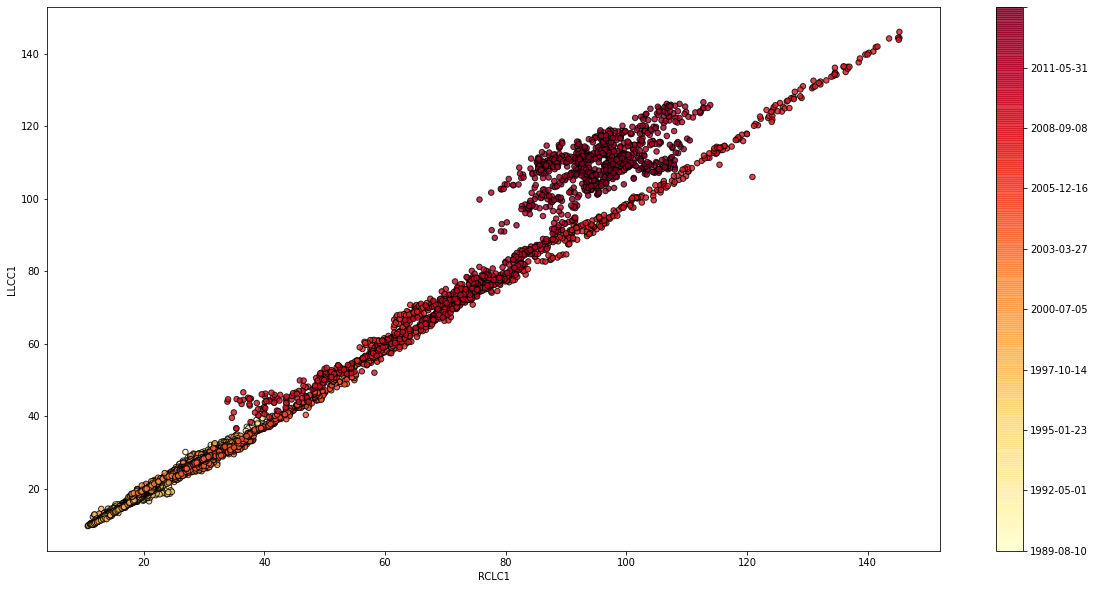

In [4]:
draw_date_coloured_scatterplot(futs, crude)

In [5]:
def calc_slope_intercept_kalman(futs, prices, delta):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    futures prices.
    """
    
    delta = delta
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[futs[0]], np.ones(prices[futs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
        
    state_means, state_covs = kf.filter(prices[futs[1]].values)
    return state_means, state_covs

In [6]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filter calculated values.
    """

    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True,figsize=(20,15))
    plt.show()

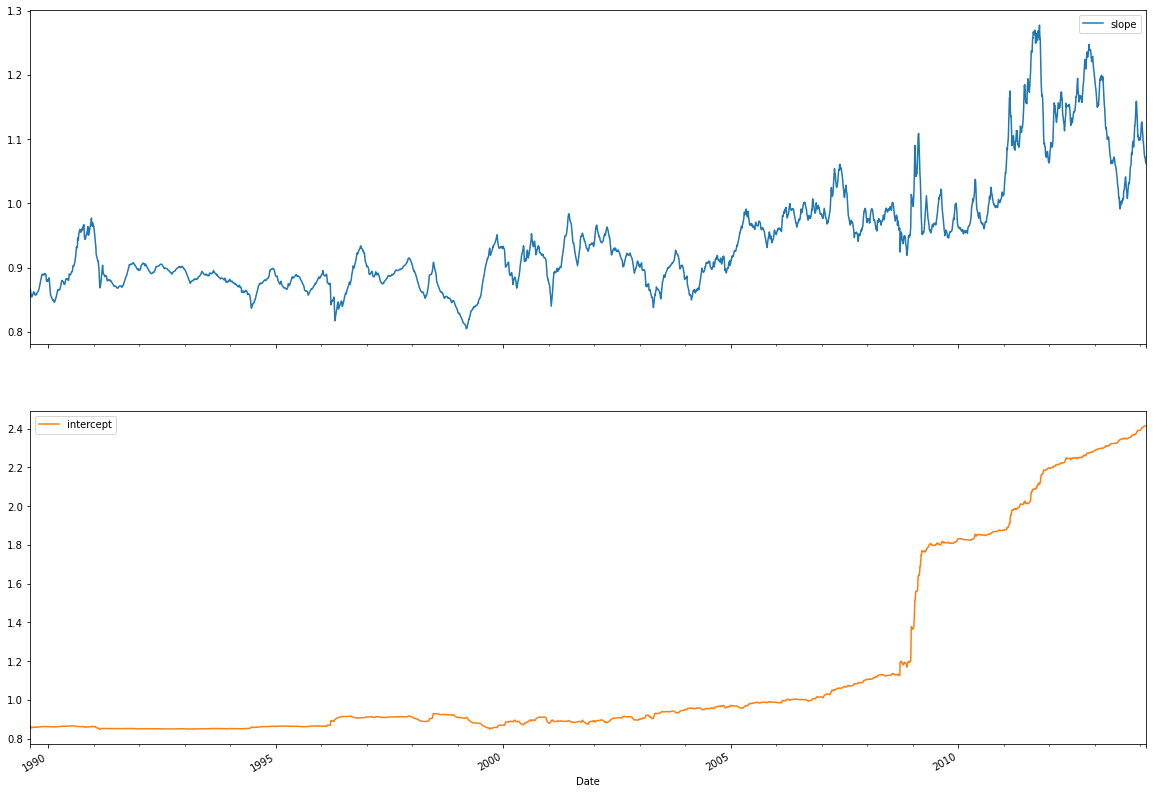

In [7]:
draw_slope_intercept_changes(crude, calc_slope_intercept_kalman(futs, crude, 1e-5)[0])

In [8]:
def mean_reversion_dynamic(df1, MA_length, exit_signal):
    '''
    Get the sharpe ratio on a mean reversion strategy over the whole period on the spread of two futures contracts. 
    The strategy involves using the bollinger band as an entry/exit signal. The entry point will be when the 
    price level hits 2 standard deviations above the moving average (whose period length is user-specificed) 
    and the exit signal is user-specified. For this variation, we use a simple 1-1 ratio of the specified contracts 
    (no hedge ratio). For return calculation, we take the average price level of the two contracts as 
    "committed capital." Finally, since contracts are rolled over on the first of each month, anytime we are in 
    the market during this time, the change in price levels is not calculated into our returns.
    '''
    
    df=df1.copy()

    # df is a dataframe with a date column, and two futures price data columns
    # MA_length is the length of the moving average we will use
    # exit_signal is the z score at which we will exit our position (+/- 2 stdevs is the entry)
    
    #read in daily risk-free rates data (obatined from WRDS)
    Rf = pd.read_csv("Rf.csv",header=0,names=['Date','Rf'])
    Rf.Date = pd.to_datetime(Rf.Date)
    
    #get relevant dates for risk free rate
    Rf = Rf[(Rf.Date >= df.Date[0]) & (Rf.Date <= df.Date[len(df.Date)-1])]
    Rf = Rf.reset_index(drop=True)
    
    
    #create updating list of hedge ratios using KalmanFilter function
    
    #create inputs for the function
    prices = df1.copy()
    prices = prices.set_index("Date",drop=True)
    futs = list(prices.columns)
    
    #run function and extract slopes (hedge ratio)
    hedge_ratio = pd.DataFrame(calc_slope_intercept_kalman(futs, prices, 1e-5)[0])
    hedge_ratio = hedge_ratio.iloc[:,0]


    #create the column for the spread
    # a "hedged portfolio" is created by hedging the front leg of the spread using the previously obtained ratio
    df['Spread'] = df.iloc[:,1]*hedge_ratio - df.iloc[:,2]
    
    #create columns for moving average, rolling standard deviation, and z-score for the current price level of the spread
    df['MA'+str(MA_length)] = df.Spread.rolling(MA_length).mean()
    df['SD'+str(MA_length)] = df.Spread.rolling(MA_length).std()
    df['Z'+str(MA_length)] = (df.Spread-df['MA'+str(MA_length)])/df['SD'+str(MA_length)]
    
    
    ## creating signal column which determines when we are long/short the spread
    #determine initial entry points, which is when z-score is above 2 or below -2
    df["Signal"] = [1 if x < -2 else (-1 if x > 2 else 0) for x in df['Z'+str(MA_length)]]
    
    # fill in signal columns until the point where we receive an exit signal (determined by "exit_signal" variable)
    for i in range(1,len(df.index)):
        if df.iloc[i-1,7] == -1:
            if df.iloc[i,6] > -1*exit_signal:
                df.iloc[i,7] = -1
        elif df.iloc[i-1,7] == 1:
            if df.iloc[i,6] < exit_signal:
                df.iloc[i,7] = 1
            
    #calculate returns; we will use the average price level of the two contracts as our investment/"employed capital"
    df['Ret'] = df.Spread.diff().shift(-1)/(df.iloc[:,1]+df.iloc[:,2])/2
    df.Ret = df.Ret*df.Signal
    
    
    #create indicator for contract roll-over days
    df['EOM'] = df.Date.shift(-1).dt.month != df.Date.dt.month
    
    #get summary statistics for returns
    returns = df.Ret[(df.Signal !=0) & (df.EOM == False)]
    returns = returns.dropna()
    stats = returns.describe()
    
    #get average daily risk free rate over the period
    stats2 = Rf.Rf.describe()

    sharpe = (stats[1]-stats2[1])/stats[2]*np.sqrt(252)
    
    return sharpe



In [9]:
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)


In [10]:
#variables to try
MA_length = [10,15,20,50,100]
exit_signal = [-0.5,-0.2,0,0.2,0.5]

#read in crude oil futures data and daily risk-free rates data (obtained from WRDS)
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)


In [11]:
# WTI Front - Brent Front Spread
df1=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC1","LLCC1"]],i,j))
    df1[str(i)] = l

df1.index = exit_signal


In [12]:
# WTI 2nd month - Brent 2nd month
df2=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC2","LLCC2"]],i,j))
    df2[str(i)] = l

df2.index = exit_signal


In [13]:
# WTI 3rd month - Brent 3rd month
df3=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC3","LLCC3"]],i,j))
    df3[str(i)] = l

df3.index = exit_signal


In [14]:
# WTI 4th month - Brent 4th month
df4=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC4","LLCC4"]],i,j))
    df4[str(i)] = l

df4.index = exit_signal



In [15]:
# WTI 5th month - Brent 5th month
df5=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC5","LLCC5"]],i,j))
    df5[str(i)] = l

df5.index = exit_signal


In [16]:
# WTI 6th month - Brent 6th month
df6=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC6","LLCC6"]],i,j))
    df6[str(i)] = l

df6.index = exit_signal


In [17]:
# WTI 1 year - Brent 1 year
df12=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC12","LLCC12"]].dropna().reset_index(drop=True),i,j))
    df12[str(i)] = l

df12.index = exit_signal


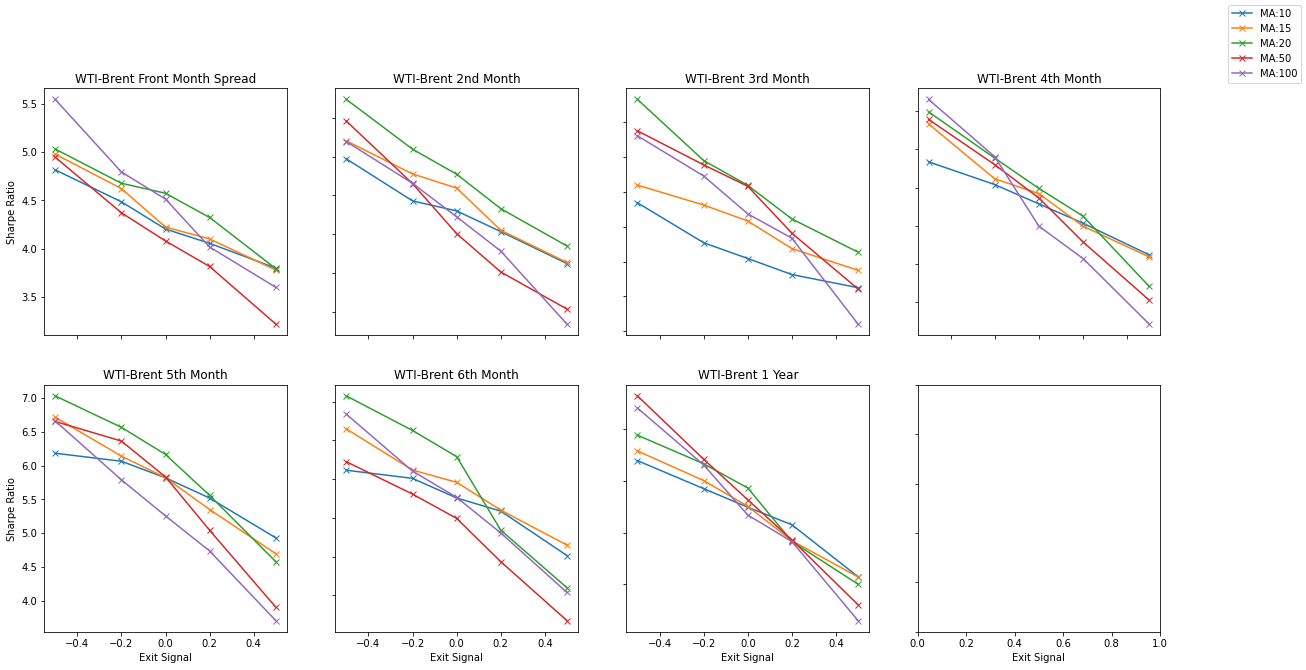

In [18]:
dfs = [df1,df2,df3,df4,df5,df6,df12]
titles = ["WTI-Brent Front Month Spread",
         "WTI-Brent 2nd Month",
         "WTI-Brent 3rd Month",
         "WTI-Brent 4th Month",
         "WTI-Brent 5th Month",
         "WTI-Brent 6th Month",
         "WTI-Brent 1 Year"]

fig, axs = plt.subplots(2, 4,figsize=(20,10))

c=0
for i in [0,1]:
    for j in [0,1,2,3]:
        if c==0:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-', label="MA:10")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-', label="MA:15")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-', label="MA:20")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-', label="MA:50")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-', label="MA:100")
            axs[i, j].set_title(titles[c])
        elif c<7:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-')
            axs[i, j].set_title(titles[c])
            
        c+=1


fig.legend()

for ax in axs.flat:
    ax.set(xlabel='Exit Signal', ylabel='Sharpe Ratio')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()